In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import json
import glob
import numpy as np
from PIL import Image
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
#from scipy.misc import imsave
from imageio import imwrite
from sklearn.cluster import DBSCAN
from shapely.geometry import box
Image.MAX_IMAGE_PIXELS = None
import tifffile as tiff

In [2]:
liebre1_rgb_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif"
liebre1_box_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_boxes.geojson"

In [3]:
def convert_coords(image, geo_image, label, x, y): 
    
    ''' 
    convert from geographic coordinates to image-scaled coordinates, relative to bottom left of image
    '''

    # get coordinates defining extent of input image and labels
    bbox = geo_image.bounds
    x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]
    
    # get distance of point x,y from image origin
    x_relative = x - x_min
    y_relative = y - y_min
        
    # get scaling factors
    width = x_max - x_min
    height = y_max - y_min
    (width_pix, height_pix) = image.size

    
    x_pix = x_relative/width * width_pix
    y_pix = y_relative/height * height_pix
    
    return x_pix, y_pix

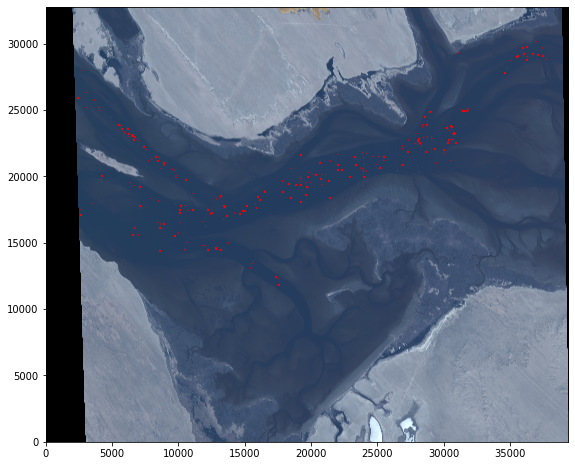

In [4]:
# visualise input image file + bounding boxes from label file
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    geotif_rgb = rasterio.open(liebre1_rgb_path)
    array_rgb = tiff.imread(liebre1_rgb_path)
    PIL_image = Image.fromarray(array_rgb)
    image = PIL_image
    # create figure
    fig1 = plt.figure(figsize=(16, 8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(np.flipud(image), origin='lower') #  flip because imshow defines upper left as origin

    # plot bounding boxes
    for object in label['features']:
        
        # get origin and dimenstions of each bounding box
        bottom_left_unconv = object['geometry']['coordinates'][0][0]
        top_right_unconv = object['geometry']['coordinates'][0][2]

        bottom_left = convert_coords(image, geotif_rgb, label, bottom_left_unconv[0], bottom_left_unconv[1])
        top_right = convert_coords(image, geotif_rgb, label, top_right_unconv[0], top_right_unconv[1])

        width = top_right[0] - bottom_left[0]
        height = top_right[1] - bottom_left[1]

        # add bounding box to figure
        rect = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        
    plt.show

In [5]:
def save_files(image, label, info, output_dir, input_name):
    
    '''
    for each cluster of bounding boxes, save a 512x512 image chip as .png
    along with bounding box labels in YOLO format as .json
    '''
    
    # initialise a figure to visualise output tiles
    fig = plt.figure(figsize=(20, 100))
    n_tiles = len(info.keys())
    
    for i,k in enumerate(info.keys()):
                             
        # get centre of each bounding box cluster
        x, y = info[k]['centre'][0], info[k]['centre'][1] # in pixels, with origin in lower left
        
        # define coordinates for cropping
        # set limits since tile boundaries cannot exceed image boundaries
        width, height = image.getbbox()[2], image.getbbox()[3]      #2,3 are right and lower bounds
        
        left, top, right, bottom = x-256, (height-y)-256, x+256, (height-y)+256 # in accordance with PIL library: in pix, origin top left
               
        left_lim, top_lim = max(0,int(left)), max(0,int(top))
        right_lim, bottom_lim = min(width, int(right)), min(height, int(bottom))
               
        # crop and save image tiles
        image_name = '{}/{}_{}.png'.format(output_dir, input_name, k)
        #image_str = file_path + '/' + image_name
        # it goes left-top-right-bottom where bottom=top+height (i.e. the origin is in the top left corner)
        image_tile = image.crop([left_lim, top_lim, right_lim, bottom_lim])

        imwrite(image_name, image_tile)

        ax = fig.add_subplot(n_tiles, 4, i+1)
        ax.imshow(image_tile)
                
        # save label file
        file = open(image_name.replace('.png', '.txt'), 'a')
        
        for j, box in enumerate(info[k]['object_boxes']):
            # get coordinates of lower left (x1) and upper right (x3) corner of bounding box
            [[x1, y1], [x3, y3]] = box # in px, origin in lower left
            
            # define bounding box coordinates relative to boundaries of current image tile
            x1_rel, x3_rel = x1-left_lim, x3-left_lim
            y1_rel, y3_rel = (height-y1)-top_lim, (height-y3)-top_lim
            
            # get some scaling factors to convert from image to tile coordinates
            tile_width = right_lim - left_lim
            tile_height = top_lim - bottom_lim

            # define bounding box centre & width
            box_centre_x = (x1_rel+x3_rel)//2
            box_centre_y = (y1_rel+y3_rel)//2
            box_width = x3-x1
            box_height = y1-y3
            
            # add bounding boxes to tile subplot
            rect = patches.Rectangle((x1_rel, y1_rel), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            title = str(i+1)
            ax.set_title(title)

            # write label to .txt file
            ## 0 means first object i.e. whale
            ## (add a line here for multiple categoties - if info[k]['name'] = 'ship': lab = ...)
            
            #
            lab = '0 {} {} {} {}\n'.format(abs(box_centre_x/tile_width), abs(box_centre_y/tile_height), abs(box_width/tile_width), abs(box_height/tile_height))
            file.write(lab)
        file.close()
    plt.show()

In [6]:
def read_coords(label):
    coords, centres = [], []
    
    for object in label['features']:
        # get coordinates of lower left & upper right corners of each bounding box
        [[x1, y1], [x3, y3]] = object['geometry']['coordinates'][0][0], object['geometry']['coordinates'][0][2]
        coords.append([[x1, y1], [x3, y3]])

        # store centre coordinate of each bounding box for clustering
        centres.append([(x1+x3)//2, (y1+y3)//2])
    return np.array(coords), centres

In [8]:
file_save_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/cropped_images"

<class 'PIL.Image.Image'>


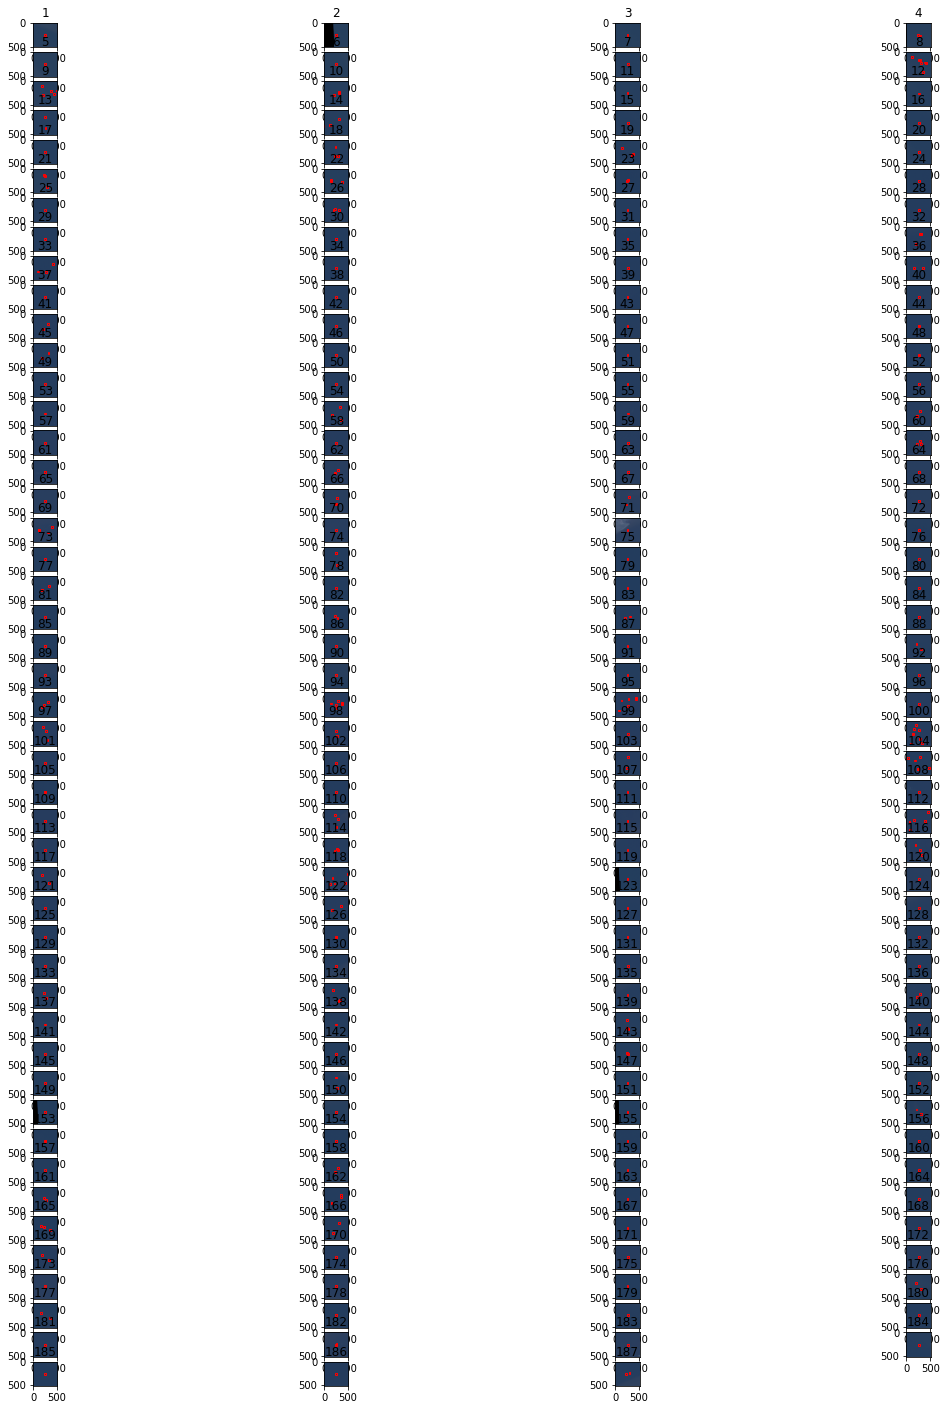

In [9]:
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    #label['imagePath'] = image_file
    geotif_rgb = rasterio.open(liebre1_rgb_path)
    array_rgb = tiff.imread(liebre1_rgb_path)
    PIL_image = Image.fromarray(array_rgb)
    image = PIL_image
    print(type(image))

    coords, centres = read_coords(label)
    
    # convert bounding box coordinates from geographic to image-scaled
    centres_converted = np.array([convert_coords(image, geotif_rgb, label, point[0], point[1]) for point in centres])
    
    coords_converted = np.array([[convert_coords(image, geotif_rgb, label, point[0][0], point[0][1]), 
                                  convert_coords(image, geotif_rgb, label, point[1][0], point[1][1])] 
                            for point in coords
                       ])    
    
    ## DB-Scan algorithm for clustering ##
    
    eps = 250 # threshold distance between two points to be in the same 'neighbourhood'
    dbscan = DBSCAN(min_samples=1, eps=eps)
    y = dbscan.fit_predict(centres_converted)

    # storing coordinates of clusters, relative to boundaries of image (not tile)
    info = {}
    for i in range(y.max()+1):
        
        # calculate the max and min coords of all the bounding boxes in the cluster
        box_centres = centres_converted[np.where(y==i)[0]]
        min_x, max_x = box_centres[:, 0].min(), box_centres[:, 0].max()
        min_y, max_y = box_centres[:, 1].min(), box_centres[:, 1].max()
        
        # assign each cluster of objects as an item
        item = {}
        item['centre'] = [(min_x+max_x)//2, (min_y+max_y)//2]
        item['object_boxes'] = coords_converted[np.where(y==i)[0]].tolist()
        item['name'] = "whale"
        info[i] = item
        
        # add a line here to generalize to multiple categories:
        # if label['features']['NumShip'] == ... : 

    save_files(image, label, info, file_save_path, 'liebre1')


In [79]:
#Visualise some of the saved files:
cropped_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/cropped_images/liebre1_0.png"
cropped_label_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/cropped_images/liebre1_0.txt"

In [80]:
cropped_image = Image.open(cropped_image_path)

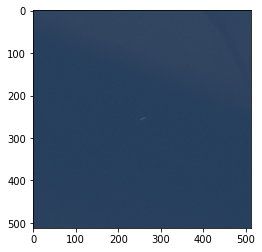

In [81]:
plt.imshow(cropped_image)

In [82]:
import pandas as pd 
boxes = pd.read_csv(cropped_label_path, sep=" ", header=None)

In [83]:
boxes

,0,1,2,3,4
0,0,0.501953,0.498047,0.078125,0.078125


In [84]:
boxes[1][0]

0.501953125

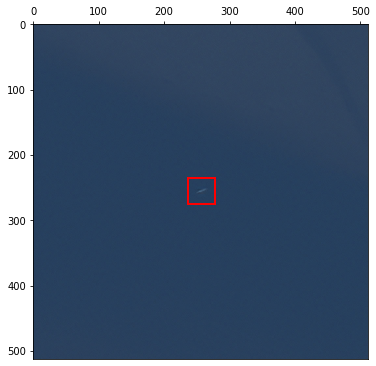

In [85]:
x = (boxes[1][0] - boxes[3][0]*0.5)*cropped_image.size[0]
y = (boxes[2][0] - boxes[4][0]*0.5)*cropped_image.size[1]
w = boxes[3][0] * cropped_image.size[0]
h = boxes[4][0] * cropped_image.size[1]
fig, ax = plt.subplots(figsize = (6,9))
ax.xaxis.tick_top()
ax.imshow(cropped_image)
ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))